# 8.2 Bagging, Random Froest, Boosting

In [24]:
# Usual Packages
import pandas as pd
import numpy as np
import random
import os
import math
os.chdir(r'E:\python3\2020_Seminar\2021春季学习班\自行实现文档\07_树方法\4.15讲解文档')

In [25]:
# Machine Learning Packages

# Train & Test Split
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Single Tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
# Bagging 
from sklearn.ensemble import BaggingClassifier,BaggingRegressor
# Random Forest
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
# Boosting
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor
# Evaluation Metrics
from sklearn import metrics
# draw figures
import matplotlib.pyplot as plt 

In [53]:
# Data processing
Heart = pd.read_csv(r'数据\Heart.csv',index_col=0).dropna()

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

qualitative_columns = ['ChestPain','Thal','AHD']
for column in qualitative_columns:
    Heart[column] = le.fit_transform(Heart[column])
  
X = Heart.drop('AHD',axis=1)
y = Heart['AHD']

Heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,3,145,233,1,2,150,0,2.3,3,0.0,0,0
2,67,1,0,160,286,0,2,108,1,1.5,2,3.0,1,1
3,67,1,0,120,229,0,2,129,1,2.6,2,2.0,2,1
4,37,1,1,130,250,0,0,187,0,3.5,3,0.0,1,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,1,0


In [55]:
# Single Classification Tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

single_tree_clf = DecisionTreeClassifier(random_state=0)
single_tree_clf.fit(X_train,y_train)
print('single_tree train_accuracy: %s'%(single_tree_clf.score(X_train,y_train)))

y_test_pred = single_tree_clf.predict(X_test)
print('single_tree test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred)))

single_tree train_accuracy: 1.0
single_tree test_accuracy: 0.697986577181208


## 8.2.1 Bagging

*Bootstrap aggregation* , or *bagging*, is a general-purpose procedure for reducing the variance of a statistical learning method.

The decision trees discussed in Section 8.1 suffer from high variance.This means that if we split the training data into two parts at random,and fit a decision tree to both halves, the results that we get could be
quite different.

Hence a natural way to reduce the variance and hence increase the prediction
accuracy of a statistical learning method is to take many training sets
from the population, build a separate prediction model using each training
set, and average the resulting predictions.

$$
\hat{f}_{\text {bag }}(x)=\frac{1}{B} \sum_{b=1}^{B} \hat{f}^{*b}(x)
$$

![title](img/bootstrap.PNG)

相同评价指标，不同样本

一、oob（Out - of - Bag）

定义：放回取样导致一部分样本很有可能没有取到，这部分样本平均大约有 37% ，把这部分没有取到的样本称为 oob 数据集；

使用OOB-袋外错误率时，可以不对数据集进行 train_test_split。也就是在全集随机有方回取样得到训练集（假设取样大小等于全集），使用没有取到的样本做测试集。

![title](img/oob.PNG)

 参数：OOB-袋外错误率

1）对每个样本，计算它作为oob样本的树对它的分类情况（约1/3的树）；

2）然后以简单多数投票作为该样本的分类结果；

3）最后用误分个数占样本总数的比率作为随机森林的oob误分率。

oob误分率是随机森林泛化误差的一个无偏估计，它的结果近似于需要大量计算的k折交叉验证。

In [27]:
# Bagging
# OOB_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

bagging_clf_OOB = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=100,random_state=0,
                               bootstrap=True, oob_score=True,n_jobs=-1)
bagging_clf_OOB.fit(X,y)
print('Bagging oob_score: %s'%(bagging_clf_OOB.oob_score_))

# test_score
bagging_clf_test = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=100,random_state=0,
                               bootstrap=True, oob_score=False,n_jobs=-1)
bagging_clf_test.fit(X_train,y_train)
y_test_pred = bagging_clf_test.predict(X_test)
print('Bagging test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred)))

Bagging oob_score: 0.7777777777777778
Bagging test_accuracy: 0.785234899328859


二、gini index

基尼指数（Gini不纯度）表示在样本集合中一个随机选中的样本被分错的概率。

Gini指数越小表示集合中被选中的样本被参错的概率越小，也就是说集合的纯度越高，反之，集合越不纯。当集合中所有样本为一个类时，基尼指数为0.

$$
G(p)=\sum_{k=1}^{K} p_{k}\left(1-p_{k}\right)=1-\sum_{k=1}^{K} p_{k}^{2}
$$

其中，pk表示样本属于第k个类别的概率

例子 **calculating the Gini Index for "Past Trend"**
![title](img/gini.png)


P(Past Trend=Positive): 6/10

P(Past Trend=Negative): 4/10

If (Past Trend = Positive & Return = Up), probability = 4/6

If (Past Trend = Positive & Return = Down), probability = 2/6

Gini index = 1 - ((4/6)^2 + (2/6)^2) = 0.45

If (Past Trend = Negative & Return = Up), probability = 0

If (Past Trend = Negative & Return = Down), probability = 4/4

Gini index = 1 - ((0)^2 + (4/4)^2) = 0

Weighted sum of the Gini Indices can be calculated as follows:

Gini Index for Past Trend = (6/10)0.45 + (4/10)0 = 0.27

In [61]:
# 默认的变量特征重要性是在所有树的节点划分中，每个变量划分带来的基尼系数增益，
# 并除总增益值使所有变量特征重要性和为1
feature_importances = np.mean([tree.feature_importances_ for tree in bagging_clf_test.estimators_], axis=0)
feature_importances

array([0.07989749, 0.02721767, 0.2538027 , 0.08467278, 0.08152659,
       0.00813797, 0.00542056, 0.14332214, 0.07200713, 0.11322623,
       0.01647739, 0.05451004, 0.05978129])

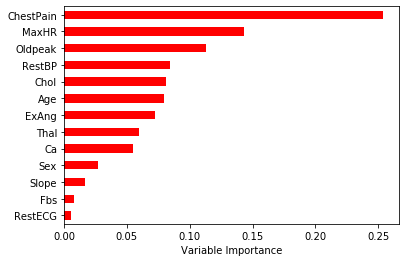

In [29]:
Importance = pd.DataFrame({'Importance':feature_importances}, index = X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [30]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

random_forest_clf_OOB = RandomForestClassifier(n_estimators=100, max_features='auto',
                                           random_state=0, oob_score=True)
random_forest_clf_OOB.fit(X, y)
print('random_forest oob_score: %s'%(random_forest_clf_OOB.oob_score_))

# test_score
random_forest_clf_test = RandomForestClassifier(n_estimators=100, max_features='auto',
                                           random_state=0, oob_score=False)
random_forest_clf_test.fit(X_train,y_train)
y_test_pred = random_forest_clf_test.predict(X_test)
print('random_forest test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred)))

random_forest oob_score: 0.8080808080808081
random_forest test_accuracy: 0.8187919463087249


In [32]:
# 生成画图所需数据表格框架
# 生成1到30整数序列（np.linspace生成的数字格式为numpy.float64，不能用于循环索引）
Error_n_trees_frame_index = range(1,31) 

Error_n_trees_frame_columns = [ 'Number of Trees', 'Bagging_test', 'RandomForest_test',
                              'Bagging_OOB', 'RandomForest_OOB','Single_test']
Error_n_trees_frame = pd.DataFrame(index = Error_n_trees_frame_index, columns = Error_n_trees_frame_columns)
Error_n_trees_frame['Number of Trees'] = np.linspace(10,300,30)

# 把生成模型并获取指标封装到短函数
def Bagging_test(tree_num):
    Bagging_model = BaggingClassifier(DecisionTreeClassifier(),
                    n_estimators= tree_num, random_state=0,
                    bootstrap=True, oob_score=True,n_jobs=-1)
    Bagging_model.fit(X_train,y_train)
    
    y_test_pred = Bagging_model.predict(X_test)
    test_error = 1- metrics.accuracy_score(y_test,y_test_pred)
    return test_error
    
def Bagging_oob(tree_num):
    Bagging_model = BaggingClassifier(DecisionTreeClassifier(),
                    n_estimators= tree_num, random_state=0,
                    bootstrap=True, oob_score=True,n_jobs=-1)
    Bagging_model.fit(X,y)
    return 1 - Bagging_model.oob_score_
    
def RandomForest_test(tree_num):
    RandomForest_model = RandomForestClassifier(n_estimators=tree_num, max_features='sqrt',
                            random_state=0, oob_score=False)
    RandomForest_model.fit(X_train,y_train)
    
    y_test_pred = RandomForest_model.predict(X_test)
    test_error = 1- metrics.accuracy_score(y_test,y_test_pred)
    return test_error

def RandomForest_oob(tree_num):
    RandomForest_model = RandomForestClassifier(n_estimators=tree_num, max_features='sqrt',
                            random_state=0, oob_score=True)
    RandomForest_model.fit(X,y)
    return 1- RandomForest_model.oob_score_

def Single_tree_test():
    single_tree_model = DecisionTreeClassifier(random_state=0,max_depth=3)
    single_tree_model.fit(X_train,y_train)
    
    y_test_pred = single_tree_model.predict(X_test)
    test_error = 1- metrics.accuracy_score(y_test,y_test_pred)
    return test_error
    
# 计算不同树个数下的分类错误率
def generate_Error_n_trees_frame():
    for i in Error_n_trees_frame_index:        
        Error_n_trees_frame.loc[i,'Bagging_test'] = Bagging_test(10 * i)
        Error_n_trees_frame.loc[i,'RandomForest_test'] = RandomForest_test(10 * i)
        Error_n_trees_frame.loc[i,'Bagging_OOB'] = Bagging_oob(10 * i)
        Error_n_trees_frame.loc[i,'RandomForest_OOB'] = RandomForest_oob(10 * i)
        Error_n_trees_frame.loc[i,'Single_test'] = Single_tree_test()
        print(i)
generate_Error_n_trees_frame()

C:\Users\W\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\W\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:643: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\W\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\W\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:643: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
C:\Users\W\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [35]:
Error_n_trees_frame.head()

,Number of Trees,Bagging_test,RandomForest_test,Bagging_OOB,RandomForest_OOB,Single_test
1,10.0,0.201342,0.208054,0.262626,0.232323,0.281879
2,20.0,0.214765,0.187919,0.225589,0.205387,0.281879
3,30.0,0.208054,0.187919,0.23569,0.205387,0.281879
4,40.0,0.194631,0.181208,0.239057,0.191919,0.281879
5,50.0,0.214765,0.181208,0.222222,0.198653,0.281879


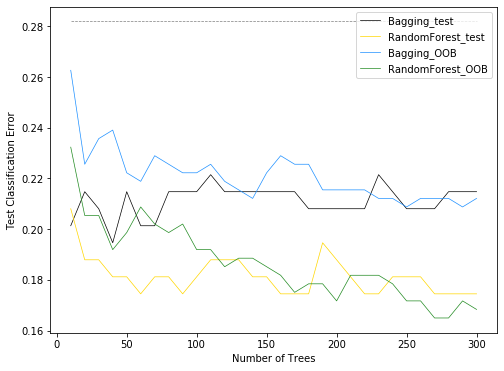

In [40]:
# 虚线是最大深度为3的单一决策树预测误差
plt.figure(figsize=(8,6))
colors = ['black','gold','dodgerblue','forestgreen']
plt.plot(Error_n_trees_frame['Number of Trees'], Error_n_trees_frame['Single_test'] ,
             label = '',linestyle = '--',linewidth = 0.7, color = 'grey')
for i in range(4):
    plt.plot(Error_n_trees_frame['Number of Trees'], Error_n_trees_frame[Error_n_trees_frame.columns[1:-1][i]] ,
             label = Error_n_trees_frame.columns[1:-1][i],linestyle = '-',linewidth = 0.7, color = colors[i])
plt.xlabel('Number of Trees')
plt.ylabel('Test Classification Error')
plt.legend(loc = 'upper right')

## 8.2.2 Random Forest

1. 用有抽样放回的方法（bootstrap）从样本集中选取n个样本作为一个训练集


2. 用抽样得到的样本集生成一棵决策树。在生成的每一个结点：


* 随机不重复地选择d个特征
* 利用这d个特征分别对样本集进行划分，找到最佳的划分特征（可用基尼系数、增益率或者信息增益判别）


3. 重复步骤1到步骤2共k次，k即为随机森林中决策树的个数。


4. 用训练得到的随机森林对测试样本进行预测，并用票选法决定预测的结果。



![title](img/Random_Forest.PNG)

In [277]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

random_forest_clf_p = RandomForestClassifier(n_estimators=100, max_features=None,
                                           random_state=0, oob_score=False)
random_forest_clf_half = RandomForestClassifier(n_estimators=100, max_features=0.5,
                                           random_state=0, oob_score=False)
random_forest_clf_sqrt = RandomForestClassifier(n_estimators=100, max_features='sqrt',
                                           random_state=0, oob_score=False)

random_forest_clf_p.fit(X_train,y_train)
random_forest_clf_half.fit(X_train,y_train)
random_forest_clf_sqrt.fit(X_train,y_train)

y_test_pred_p = random_forest_clf_p.predict(X_test)
y_test_pred_half = random_forest_clf_half.predict(X_test)
y_test_pred_sqrt = random_forest_clf_sqrt.predict(X_test)

print('random_forest test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_p)))
print('random_forest test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_half)))
print('random_forest test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_sqrt)))

random_forest test_accuracy: 0.7986577181208053
random_forest test_accuracy: 0.8053691275167785
random_forest test_accuracy: 0.8187919463087249


In [64]:
# 生成画图所需数据表格框架
frame_index = range(1,51) 
frame_columns = [ 'Number of Trees', 'm=p','m=p/2','m=sqrt(p)']
frame = pd.DataFrame(index = frame_index, columns = frame_columns)
frame['Number of Trees'] = np.linspace(10,500,50)

In [67]:
# 把设置不同参数的随机森林模型并获取指标封装到一个短函数
def RandomFroest(tree_num, max_feature):
    model = RandomForestClassifier(n_estimators=tree_num, max_features=max_feature,
                            random_state=0, oob_score=False)
    model.fit(X_train,y_train)
    
    y_test_pred = model.predict(X_test)
    test_error = 1- metrics.accuracy_score(y_test,y_test_pred)
    return test_error

# 计算不同特征选取比例下的分类错误率
def generate_frame():
    for i in frame_index:        
        frame.loc[i,'m=p'] = RandomFroest(10 * i, None)
        frame.loc[i,'m=p/2'] = RandomFroest(10 * i, 0.5)
        frame.loc[i,'m=sqrt(p)'] = RandomFroest(10 * i, 'sqrt')
        print(i)
generate_frame()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [66]:
frame.head()

,Number of Trees,m=p,m=p/2,m=sqrt(p)
1,10.0,0.234899,0.221477,0.208054
2,20.0,0.221477,0.194631,0.187919
3,30.0,0.221477,0.208054,0.187919
4,40.0,0.214765,0.194631,0.181208
5,50.0,0.208054,0.181208,0.181208


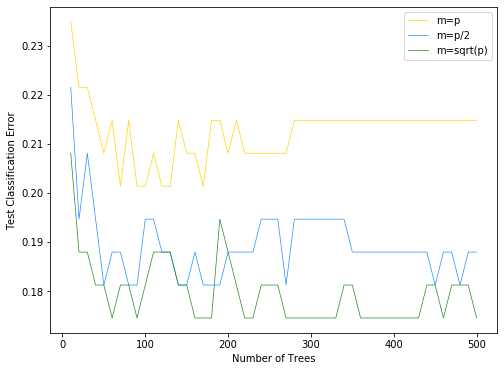

In [68]:
plt.figure(figsize=(8,6))
colors = ['gold','dodgerblue','forestgreen']
for i in range(3):
    plt.plot(frame['Number of Trees'], frame[frame.columns[1:][i]] ,
             label = frame.columns[1:][i],linestyle = '-',linewidth = 0.7, color = colors[i])
plt.xlabel('Number of Trees')
plt.ylabel('Test Classification Error')
plt.legend()

bagging is simply a special case of
a random forest with m = p.

## 8.2.3 Boosting

boosting的算法思路如下：

1. 对于训练集的每个样本建立权值wi，增大被误分类的样本的权值


2. 进行迭代的过程中，每一步迭代都是一个弱分类器，需要用某种策略将其组合，作为最终模型。（例如AdaBoost给每个弱分类器一个权值，将其线性组合为最终分类器。误差越小的弱分类器，权值越大）

以残差为衡量误分类标准为例
![title](img/boosting原理.PNG)

Boosting has three tuning parameters:
    
1. The number of trees B. Unlike bagging and random forests, boosting
can overfit if B is too large, although this overfitting tends to occur
slowly if at all. We use cross-validation to select B.


2. The shrinkage parameter λ, a small positive number. This controls the
rate at which boosting learns. Typical values are 0.01 or 0.001, and
the right choice can depend on the problem. Very small λ can require
using a very large value of B in order to achieve good performance.


3. The number d of splits in each tree, which controls the complexity
of the boosted ensemble. Often d = 1 works well, in which case each
tree is a stump, consisting of a single split.

In [89]:
# Boosting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

boosting_clf_depth_1 =GradientBoostingClassifier(max_depth=1, n_estimators=1000, learning_rate=0.01, random_state=0)
boosting_clf_depth_2 =GradientBoostingClassifier(max_depth=2, n_estimators=1000, learning_rate=0.01, random_state=0)

boosting_clf_depth_1.fit(X_train,y_train)
boosting_clf_depth_2.fit(X_train,y_train)

y_test_pred_depth_1 = boosting_clf_depth_1.predict(X_test)
y_test_pred_depth_2 = boosting_clf_depth_2.predict(X_test)

print('Boosting test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_depth_1)))
print('Boosting test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred_depth_2)))

Boosting test_accuracy: 0.8053691275167785
Boosting test_accuracy: 0.8322147651006712


由于boosting方法步长较少，树迭代次数较多，多次训练提升树模型运行时间较长，此处插入教材图片
![title](img/boosting.PNG)

# 8.3 Lab

## 8.3.3 Bagging and Random Forests

In [92]:
# 13 features in dataset
boston_df = pd.read_csv('数据/Boston.csv')
boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [93]:
X = boston_df.drop('medv', axis=1)
y = boston_df.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [150]:
# Bagging
regr1 = BaggingRegressor(base_estimator = DecisionTreeRegressor(),n_estimators=100)
regr1.fit(X_train, y_train)
pred = regr1.predict(X_test)
metrics.mean_squared_error(y_test, pred)

16.323799039525692

Text(0, 0.5, 'y_test')

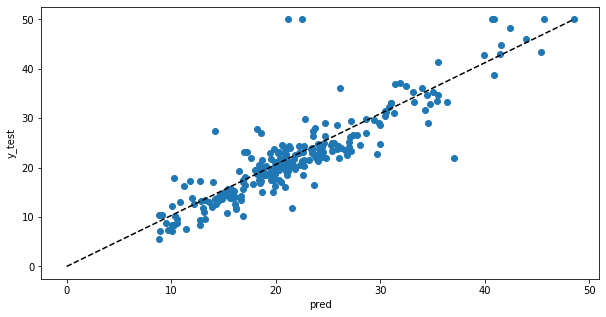

In [154]:
plt.figure(figsize=(10,5))
plt.scatter(pred, y_test, label='medv')
plt.plot([0, max(pred)], [0, max(y_test)], '--k')
plt.xlabel('pred')
plt.ylabel('y_test')

In [151]:
# Random forests: using 6 features
regr2 = RandomForestRegressor(max_features=6, random_state=0,n_estimators=100)
regr2.fit(X_train, y_train)
pred = regr2.predict(X_test)
metrics.mean_squared_error(y_test, pred)

16.0181136798419

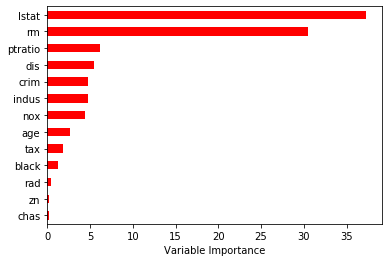

In [157]:
Importance = pd.DataFrame({'Importance':regr2.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 8.3.4 Boosting

In [142]:
regr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, random_state=0)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
metrics.mean_squared_error(y_test, regr.predict(X_test))

15.55180215646078

zn          0.013059
chas        0.121257
rad         0.153199
black       0.460309
indus       0.576559
nox         0.731767
age         0.922677
tax         1.098078
crim        2.799589
ptratio     4.370389
dis         5.896297
rm         27.934202
lstat      54.922618
dtype: float64


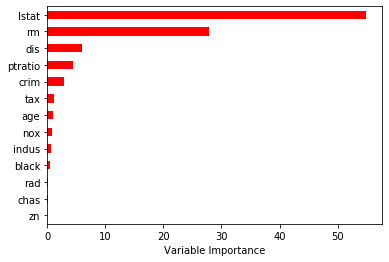

In [138]:
feature_importance = regr.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# Appendix: Tree Regression in *Machine Learning in Action*

以下代码以字典结构创建了一颗回归树：

In [7]:
from numpy import *
from pylab import plot, show
import os
## 数据载入
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

## 数据处理
# 通过数组过滤，将数据集切分成两个子集
def binSplitDataSet(dataSet, feature, value):
    mat0 = dataSet[nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0,mat1

In [11]:
# 测试数据集切分函数
testMat = mat(eye(4))
print(testMat)

mat0, mat1 = binSplitDataSet(testMat,1,0.5)
print(mat0,mat1)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[0. 1. 0. 0.]] [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [44]:
## 回归树的切分函数
# 生成叶节点——目标变量的均值
def regLeaf(dataSet):  # returns the value used for each leaf
    return mean(dataSet[:, -1])

# 误差估计函数_目标变量的平方误差
def regErr(dataSet):
    return var(dataSet[:, -1]) * shape(dataSet)[0]

# 核心函数—— 寻找最佳切分点
def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    # 停止设定变量
    tolS = ops[0]  # 容许的误差一下降值
    tolN = ops[1]  # 切分最小样本数
    # if all the target variables are the same value: quit and return value
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1:  # exit cond 1
        return None, leafType(dataSet)

    # 初始化
    m, n = shape(dataSet)
    # the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet)
    bestS = inf
    bestIndex = 0
    bestValue = 0

    # 在所有特征值和和这个特征值的所有取值上遍历
    for featIndex in range(n - 1):
        for splitVal in set(dataSet[:, featIndex].T.tolist()[0]):
            # 切分
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            # 寻找最低误差切分
            if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN): continue
            newS = errType(mat0) + errType(mat1)
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS

    # if the decrease (S-bestS) is less than a threshold don't do the split
    if (S - bestS) < tolS:
        return None, leafType(dataSet)  # exit cond 2
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    
    # if 切分出的数据集太小—— 抛弃这个切分
    if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN):  # exit cond 3
        return None, leafType(dataSet)
    return bestIndex, bestValue  # returns the best feature to split on and the value used for that split

## 创建树的整体函数
def createTree(dataSet, leafType=regLeaf, errType=regErr,
               ops=(1, 4)):  # assume dataSet is NumPy Mat so we can array filtering
    # 数据集切分——训练集和便签集
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)  # choose the best split
    # Todo:确定最佳切分的函数在后面实现
    
    # 递归停止条件
    if feat == None:
        return val  # if the splitting hit a stop condition return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree

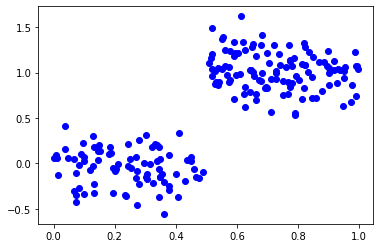

In [17]:
myDat = loadDataSet(r'数据\ex00.txt')
myMat = mat(myDat)
plot(myMat[:,0],myMat[:,1], 'bo')
show()

In [46]:
print(createTree(myMat))

{'spInd': 0, 'spVal': 0.48813, 'left': 1.0180967672413792, 'right': -0.04465028571428572}


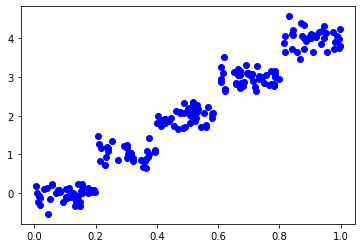

In [50]:
myDat1 = loadDataSet(r'数据\ex0.txt')
myMat1 = mat(myDat1)
plot(myMat1[:,1],myMat1[:,2], 'bo')
show()

In [51]:
print(createTree(myMat1))

{'spInd': 1, 'spVal': 0.39435, 'left': {'spInd': 1, 'spVal': 0.582002, 'left': {'spInd': 1, 'spVal': 0.797583, 'left': 3.9871632, 'right': 2.9836209534883724}, 'right': 1.980035071428571}, 'right': {'spInd': 1, 'spVal': 0.197834, 'left': 1.0289583666666666, 'right': -0.023838155555555553}}
